In [1]:
using PyPlot
using BSON: @load,@save;
#using Interpolations
#using PyCall
#scipy = pyimport("scipy.optimize")
using StatsBase
using ProgressMeter
#using Distributed
using LinearAlgebra
using Statistics

using LaTeXStrings
using Distributed
using ParallelDataTransfer
using SharedArrays
using StatsBase

rc("axes", labelsize=20,titlesize=20)
rc("font", family="STIXGeneral",serif="Times New Roman")
#rc("axes", titlesize="small", labelsize=20)
rc("xtick", labelsize=20)
#rc("xtick.major", width=linewidth/2)
rc("ytick", labelsize=20)
#rc("ytick.major", width=linewidth/2)
rc("text.latex.unicode")
rc("legend", fontsize=15)
#rc("legend", fontsize=20)
rc("text", usetex=true)
rc("savefig", transparent=true, format="pdf")


#Color scheme for thesis
color1=(176/255, 56/255, 50/255);
color2=(255/255, 99/255, 82/255);
color3=(255/255, 167/255, 36/255);
color4="gray";
color5=(23/255, 175/255, 181/255);
color6=(19/255, 78/255, 111/255);
color7=(7/255, 36/255, 72/255);

#Test for adding to color3
test1=(245/255,185/255,40/255);
test2=(255/255, 167/255, 36/255);
test3=(255/255,191/255,0/255);
test4=(255/255,145/255,85/255);
test5=(210/255,105/255,30/255);
test6=(220/255,160/255,50/255);

#Test for color0
color0test1=(120/255,30/255,25/255)
color0test2=(140/255,40/255,35/255)
color0test3=(90/255,20/255,20/255)
color0test4=(100/255,25/255,25/255)
color0test5=(110/255,35/255,30/255)

#Alphas for color1
color1alpha06=(176/255, 56/255, 50/255,0.6);

# Computing the fractal dimension of integer-dimensional curves

In [2]:
# We create the x axis
x=collect(1:0.01:300);

# We create the y axis
y=x.^2;

# We normalize each axis to [0,1] to avoid unit bias
x_norm = (x .- minimum(x)) ./ (maximum(x) .- minimum(x));
y_norm = (y .- minimum(y)) ./ (maximum(y) .- minimum(y));

# We create the curve as a set of points (x,y) in 2D, a 2xN matrix where N is the number of points
curve = hcat(x_norm,y_norm)'; # 2xN matrix
# We create the bounding box after normalisation 
mins=[minimum(x_norm),minimum(y_norm)];
maxs=[maximum(x_norm),maximum(y_norm)];

In [ ]:
close()
subplot(121)
plot(x, y)
xlabel(L"$x$")
ylabel(L"$y$")
title("Original curve")
subplot(122)
plot(x_norm, y_norm)
xlabel(L"$x$")
ylabel(L"$y$")
title("Normalized curve")
tight_layout()
display(gcf())

In [13]:
# We define the box sizes to be used. We must space them logarithmically to avoid bias, and look for the linear region in the log-log plot.
n_scales = 24; # Number of box sizes to use
fmin = 0.04; # Minimum box size as a fraction of the bounding box
fmax = 0.08; # Maximum box size as a fraction of the bounding box
eps_array = exp.(range(log(fmax), log(fmin), length=n_scales)); # Box sizes in decreasing order

In [14]:
# We define the box counting function that counts the number of boxes of size eps that contain at least one point of the curve
function count_boxes_2d(curve, eps, mins, maxs)
    # We compute the number of boxes in each dimension
    n_boxes = ceil.((maxs .- mins) ./ eps); # Number of boxes in each dimension
    n_boxes = Int.(n_boxes); # Convert to integer
    # We create a set to store the unique box indices that contain at least one point of the curve
    box_indices = Set{Tuple{Int,Int}}();
    # We loop over the points of the curve and compute the box index for each point
    for i in 1:size(curve,2)
        point = curve[:,i];
        box_index = Tuple(floor.((point .- mins) ./ eps) .+ 1); # Box index (1-based)
        push!(box_indices, box_index); # Add the box index to the set
    end
    return length(box_indices); # Return the number of unique boxes that contain at least one point of the curve
end

count_boxes_2d (generic function with 1 method)

Fractal dimension D = -1.00480213873211


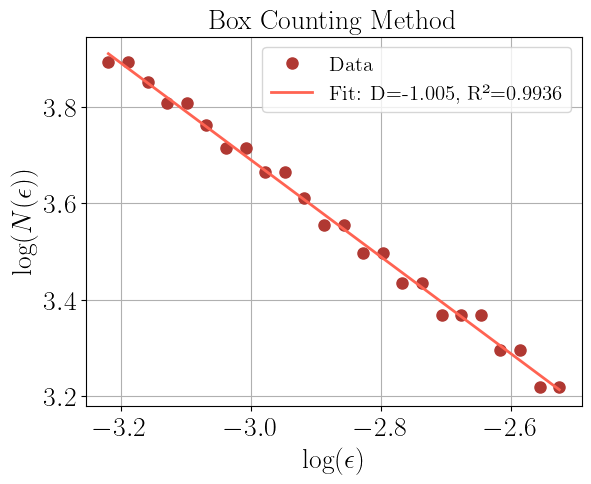

In [15]:
Ns = [count_boxes_2d(curve, e, mins, maxs) for e in eps_array]; # Number of boxes for each box size
# We perform a linear fit to the log-log data log N(eps) vs log(1/eps) to extract the fractal dimension D. We drop any degenerate counts (Ns=0 or Ns=1)
mask = Ns.>1 .& .!isnan.(Ns) .& .!isinf.(Ns); # Mask to drop degenerate counts and NaNs/Infs
log_eps = log.(eps_array[mask]);
log_Ns = log.(Ns[mask]);

# We perform a linear fit using the least squares method
mx, my = mean(log_eps), mean(log_Ns);
D = sum((log_eps .- mx) .* (log_Ns .- my)) / sum((log_eps .- mx).^2); # Fractal dimension slope = D
intercept = my - D * mx; # Intercept
println("Fractal dimension D = $D");
yhat = D * log_eps .+ intercept; # Fitted values
R2 = 1 - sum((log_Ns .- yhat).^2) / sum((log_Ns .- my).^2); # R^2 value

close();
plot(log_eps, log_Ns, "o", color=color1, label="Data", markersize=8);
plot(log_eps, yhat, "-", color=color2, label="Fit: D=$(round(D,digits=3)), R²=$(round(R2,digits=4))", linewidth=2);
xlabel(L"\log(\epsilon)");
ylabel(L"\log(N(\epsilon))");
title("Box Counting Method");
grid(true);
legend();
display(gcf());

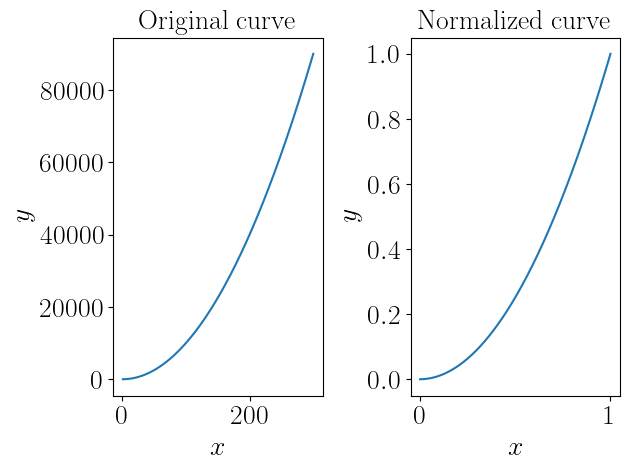

# Testing on the Koch curve

The Koch curve has a box-counting dimension $D_{Koch}=\frac{\log 4}{\log 3} \approx 1.261859$. Let's test this

In [17]:
function koch_curve(iterations::Int)
    pts = [0.0 1.0; 0.0 0.0]  # columns are points (x;y)
    for _ in 1:iterations
        newpts = Float64[]
        for i in 1:(size(pts,2)-1)
            p = pts[:,i]; q = pts[:,i+1]
            v = q - p
            a = p
            b = p + v/3
            d = p + 2v/3
            # rotate v/3 by +60° around b
            c = b .+ [cos(pi/3) -sin(pi/3); sin(pi/3) cos(pi/3)] * (v/3)
            append!(newpts, (a[1],a[2], b[1],b[2], c[1],c[2], d[1],d[2]))
        end
        append!(newpts, vec(pts[:,end]))
        pts = reshape(newpts, 2, length(newpts)÷2)
    end
    return pts # (2,N)
end

koch_curve (generic function with 1 method)

In [18]:
# --- 2) Normalize points to [0,1]×[0,1] to avoid unit bias ---
function normalize01!(pts::Matrix{<:Real})
    mins = minimum(pts; dims=2)[:]
    maxs = maximum(pts; dims=2)[:]
    span = max.(maxs .- mins, fill(eps(), 2))  # avoid zero span
    ptsn = Array{Float64}(undef, size(pts))
    @inbounds for j in 1:size(pts,2), i in 1:2
        ptsn[i,j] = (pts[i,j] - mins[i]) / span[i]
    end
    return ptsn, (mins, maxs)
end

normalize01! (generic function with 1 method)

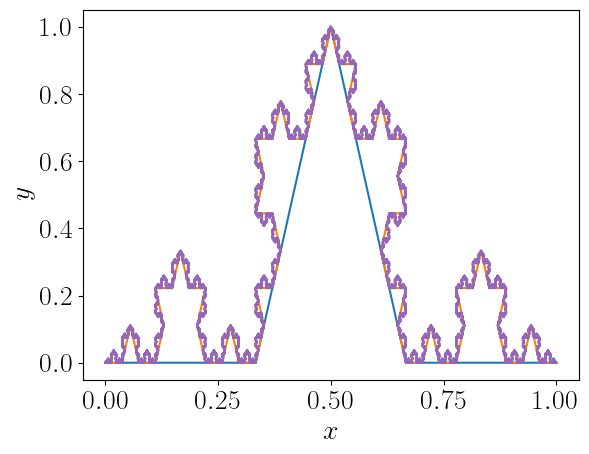

In [37]:
close()
indexcolor = -1
for i in 1:2:10
    indexcolor += 1
    pts = koch_curve(i)
    ptsn, (mins,maxs) = normalize01!(pts)
    plot(ptsn[1,:], ptsn[2,:], color="C$indexcolor")
    xlabel(L"$x$")
    ylabel(L"$y$")
    #title("Koch curve ($i iterations)")
end
display(gcf())


Fractal dimension D = 1.2734924624736677


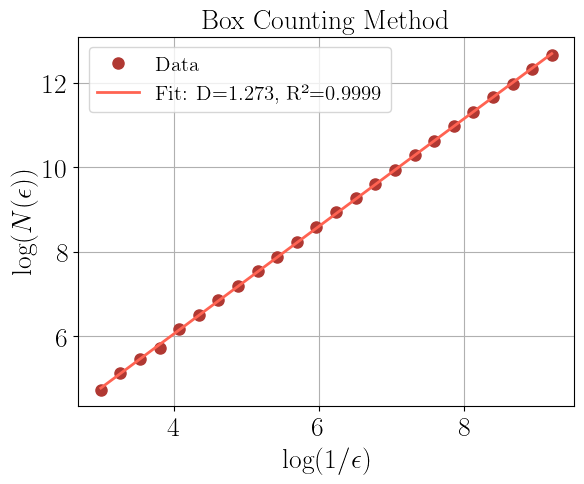

In [55]:
pts = koch_curve(10); # Koch curve with 5 iterations
ptsn, (mins,maxs) = normalize01!(pts)
# We define the box sizes to be used. We must space them logarithmically to avoid bias, and look for the linear region in the log-log plot.
n_scales = 24; # Number of box sizes to use
fmin = 0.0001; # Minimum box size as a fraction of the bounding box
fmax = 0.05; # Maximum box size as a fraction of the bounding box
eps_array = exp.(range(log(fmax), log(fmin), length=n_scales)); # Box sizes in decreasing order

Ns = [count_boxes_2d(ptsn, e, mins, maxs) for e in eps_array]; # Number of boxes for each box size
# We perform a linear fit to the log-log data log N(eps) vs log(1/eps) to extract the fractal dimension D. We drop any degenerate counts (Ns=0 or Ns=1)
mask = Ns.>1 .& .!isnan.(Ns) .& .!isinf.(Ns); # Mask to drop degenerate counts and NaNs/Infs
log_eps = log.(1.0 ./ eps_array[mask]);
log_Ns = log.(Ns[mask]);

# We perform a linear fit using the least squares method
mx, my = mean(log_eps), mean(log_Ns);
D = sum((log_eps .- mx) .* (log_Ns .- my)) / sum((log_eps .- mx).^2); # Fractal dimension slope = D
intercept = my - D * mx; # Intercept
println("Fractal dimension D = $D");
yhat = D * log_eps .+ intercept; # Fitted values
R2 = 1 - sum((log_Ns .- yhat).^2) / sum((log_Ns .- my).^2); # R^2 value

close();
plot(log_eps, log_Ns, "o", color=color1, label="Data", markersize=8);
plot(log_eps, yhat, "-", color=color2, label="Fit: D=$(round(D,digits=3)), R²=$(round(R2,digits=4))", linewidth=2);
xlabel(L"\log(1/\epsilon)");
ylabel(L"\log(N(\epsilon))");
title("Box Counting Method");
grid(true);
legend();
display(gcf());

In [56]:
# 1) Resample polyline so points are at most `step` apart
function resample_polyline(pts::Matrix{<:Real}, step::Real)
    @assert size(pts,1) == 2
    outx = Float64[]; outy = Float64[]
    push!(outx, pts[1,1]); push!(outy, pts[2,1])
    for j in 1:size(pts,2)-1
        x1,y1 = pts[1,j], pts[2,j]
        x2,y2 = pts[1,j+1], pts[2,j+1]
        dx, dy = x2-x1, y2-y1
        seglen = hypot(dx,dy)
        nseg = max(1, ceil(Int, seglen/step))
        for t in 1:nseg
            u = t / nseg
            push!(outx, x1 + u*dx)
            push!(outy, y1 + u*dy)
        end
    end
    return hcat(outx, outy)'  # (2, Nnew)
end

resample_polyline (generic function with 1 method)

In [57]:
# 2) Count boxes with random offset averaging
function count_boxes_2d_offset(pts::AbstractMatrix{<:Real}, ε::Real, ox::Real, oy::Real)
    occ = Set{Tuple{Int,Int}}()
    @inbounds for j in 1:size(pts,2)
        i = Int(floor((pts[1,j] + ox) / ε))
        k = Int(floor((pts[2,j] + oy) / ε))
        push!(occ, (i,k))
    end
    return length(occ)
end

function avg_counts_over_offsets(pts, ε; m=8)
    s = 0.0
    for _ in 1:m
        ox, oy = rand()*ε, rand()*ε
        s += count_boxes_2d_offset(pts, ε, ox, oy)
    end
    return s / m
end

avg_counts_over_offsets (generic function with 1 method)

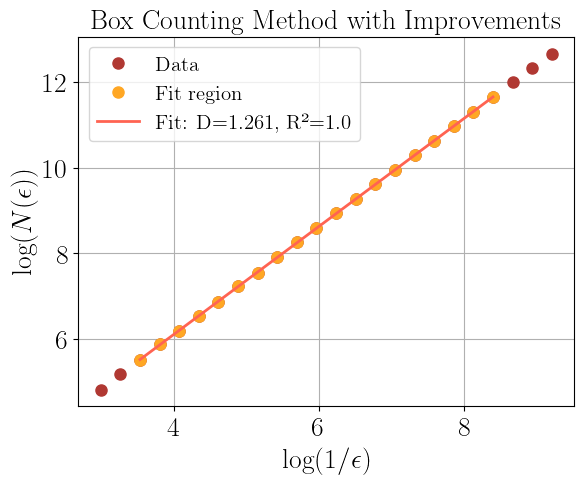

D ≈ 1.2610397673544005   R² = 0.9999853069926161   (theory: log(4)/log(3) ≈ 1.2618595071429148)


In [59]:
# --- Your script with the three improvements ---
pts = koch_curve(10)
ptsn, _ = normalize01!(pts)

# densify using the finest scale
n_scales = 24
fmin, fmax = 1e-4, 0.05
eps_array = exp.(range(log(fmax), log(fmin), length=n_scales))
ptsn_dense = resample_polyline(ptsn, minimum(eps_array)/3)

# averaged counts (reduces grid-alignment bias)
Ns = [avg_counts_over_offsets(ptsn_dense, e; m=8) for e in eps_array]

# fit on middle scales
mask = Ns .> 1
x = log.(1.0 ./ eps_array[mask])
y = log.(float.(Ns[mask]))
i1, i2 = 3, length(x)-3      # trim 3 scales at each end; tweak 2–4 as needed
xw, yw = x[i1:i2], y[i1:i2]

mx, my = mean(xw), mean(yw)
D  = sum((xw .- mx) .* (yw .- my)) / sum((xw .- mx).^2)
a  = my - D*mx
R2 = 1 - sum((yw .- (a .+ D .* xw)).^2) / sum((yw .- my).^2)

close()
plot(x, y, "o", color=color1, label="Data", markersize=8);
plot(xw, yw, "o", color=color3, label="Fit region", markersize=8);
plot(xw, a .+ D .* xw, "-", color=color2, label="Fit: D=$(round(D,digits=3)), R²=$(round(R2,digits=4))", linewidth=2);
xlabel(L"\log(1/\epsilon)");
ylabel(L"\log(N(\epsilon))");
title("Box Counting Method with Improvements");
grid(true);
legend();
display(gcf());
println("D ≈ ", D, "   R² = ", R2, "   (theory: log(4)/log(3) ≈ ", log(4)/log(3), ")")

In [63]:
function fractal_dimension_calculation(pts::Matrix{<:Real}; n_scales::Int, fmin::Real, fmax::Real, m::Int, trim::Int)

    # Normalize points to [0,1]×[0,1] to avoid unit bias
    mins = minimum(pts; dims=2)[:]
    maxs = maximum(pts; dims=2)[:]
    span = max.(maxs .- mins, fill(eps(), 2))  # avoid zero span
    ptsn = Array{Float64}(undef, size(pts))
    @inbounds for j in 1:size(pts,2), i in 1:2
        ptsn[i,j] = (pts[i,j] - mins[i]) / span[i]
    end

    #ptsn, _ = normalize01!(pts)

    # Define the box sizes to be used. We must space them logarithmically to avoid bias, and look for the linear region in the log-log plot.
    eps_array = exp.(range(log(fmax), log(fmin), length=n_scales)); # Box sizes in decreasing order

    # Densify using the finest scale
    ptsn_dense = resample_polyline(ptsn, minimum(eps_array)/3)

    # Averaged counts (reduces grid-alignment bias)
    Ns = [avg_counts_over_offsets(ptsn_dense, e; m=m) for e in eps_array]

    # Fit on middle scales
    mask = Ns .> 1
    x = log.(1.0 ./ eps_array[mask])
    y = log.(float.(Ns[mask]))
    i1, i2 = trim, length(x)-trim      # trim `trim` scales at each end; tweak 2–4 as needed
    xw, yw = x[i1:i2], y[i1:i2]

    mx, my = mean(xw), mean(yw)
    D  = sum((xw .- mx) .* (yw .- my)) / sum((xw .- mx).^2)
    a  = my - D*mx
    R2 = 1 - sum((yw .- (a .+ D .* xw)).^2) / sum((yw .- my).^2)
    close()
    plot(x, y, "o", color=color1, label="Data", markersize=8);
    plot(xw, yw, "o", color=color3, label="Fit region", markersize=8);
    plot(xw, a .+ D .* xw, "-", color=color2, label="Fit: D=$(round(D,digits=3)), R²=$(round(R2,digits=4))", linewidth=2);
    xlabel(L"\log(1/\epsilon)");
    ylabel(L"\log(N(\epsilon))");
    title("Box Counting Method");
    grid(true);
    legend();
    display(gcf());
    println("D ≈ ", D, "   R² = ", R2,")")

    return D, R2, x, y, xw, yw, a
end
    

fractal_dimension_calculation (generic function with 1 method)

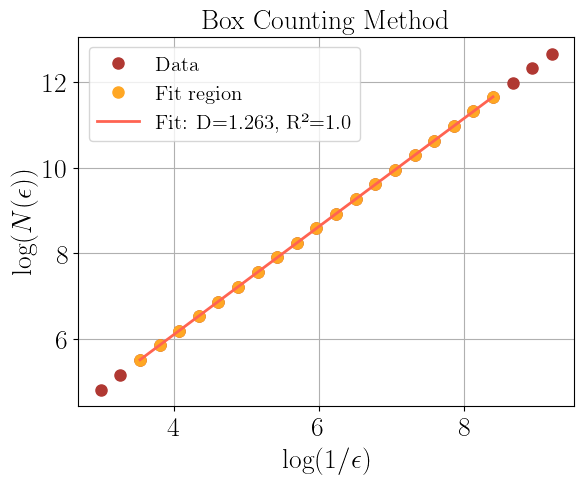

D ≈ 1.2628266586188321   R² = 0.9999913245998423)


In [65]:
fractal_dimension_calculation(koch_curve(10); n_scales=24, fmin=1e-4, fmax=0.05, m=8, trim=3);